# KLASIFIKASI "NEWS CATEGORY DATASET" (KAGGLE)

https://www.kaggle.com/datasets/rmisra/news-category-dataset

Tegar Haris DD - A11.2022.14428

## About Dataset

This dataset contains around 210k news headlines from 2012 to 2022 from HuffPost. This is one of the biggest news datasets and can serve as a benchmark for a variety of computational linguistic tasks. HuffPost stopped maintaining an extensive archive of news articles sometime after this dataset was first collected in 2018, so it is not possible to collect such a dataset in the present day. Due to changes in the website, there are about 200k headlines between 2012 and May 2018 and 10k headlines between May 2018 and 2022.

Content
Each record in the dataset consists of the following attributes:

category: category in which the article was published.
headline: the headline of the news article.
authors: list of authors who contributed to the article.
link: link to the original news article.
short_description: Abstract of the news article.
date: publication date of the article.

## Import Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils import resample
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, AdamW
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

c:\Users\tegar\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tegar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\tegar\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tegar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Load Dataset

Karena seluruh dataset sangat besar kita load 5000 record untuk 5 kategori berita yang kita pilih.

In [2]:
# 1. Load Dataset
print("Loading dataset...")
df = pd.read_json('News_Category_Dataset_v3.json', lines=True)

# Pilih 5 kategori
categories = ['POLITICS', 'ENTERTAINMENT', 'SPORTS', 'STYLE & BEAUTY', 'BUSINESS']

# Filter data
df = df[df['category'].isin(categories)]

# Sampling 5000 per kategori
sampled_dfs = []
for category in categories:
    category_df = df[df['category'] == category]
    if len(category_df) > 5000:
        category_df = category_df.sample(5000, random_state=42)
    sampled_dfs.append(category_df)

df = pd.concat(sampled_dfs)
df['text'] = df['headline'] + " " + df['short_description']


Loading dataset...


## Preprocessing Data

Pembersihan teks dengan melakukan lowercasing, tokenisasi, stopword removal, dan stemming/lemmatization.

Visualisasikan distribusi data

In [3]:
# 2. Preprocessing
print("Preprocessing data...")
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Lowercasing
    text = text.lower()
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Tokenization
    tokens = nltk.word_tokenize(text)
    # Stopword removal and lemmatization
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

df['cleaned_text'] = df['text'].apply(preprocess_text)

Preprocessing data...


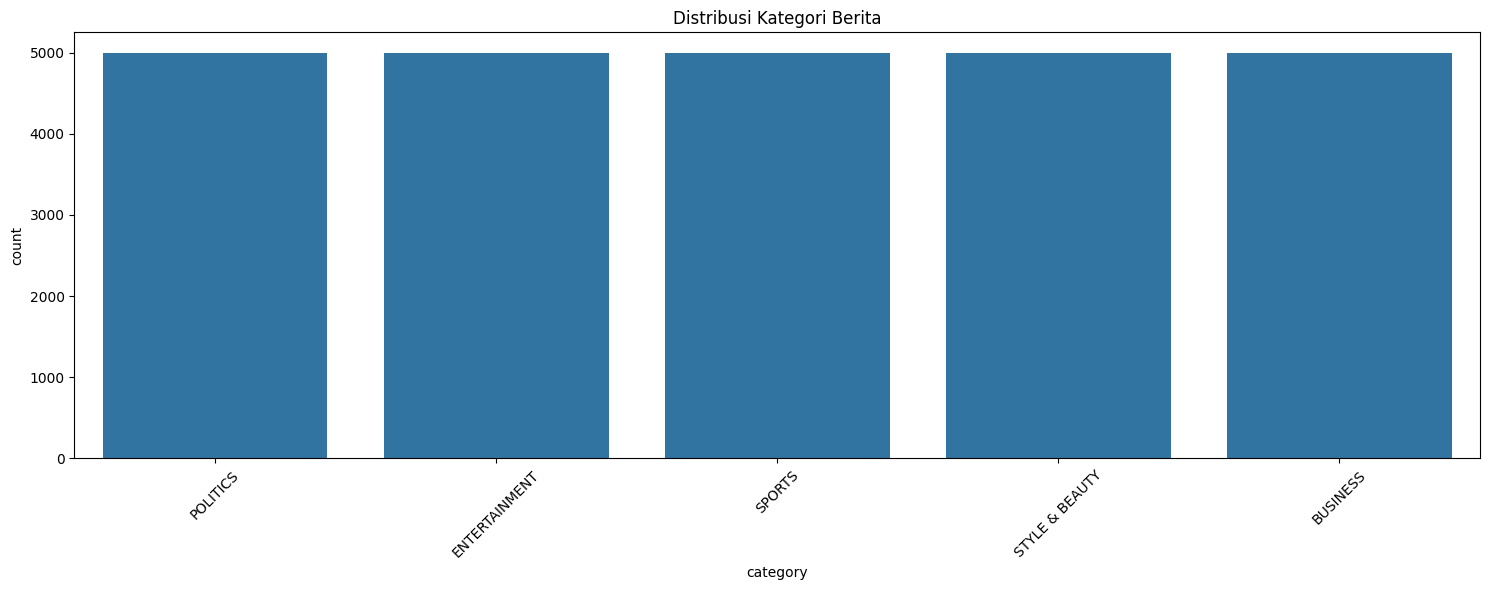

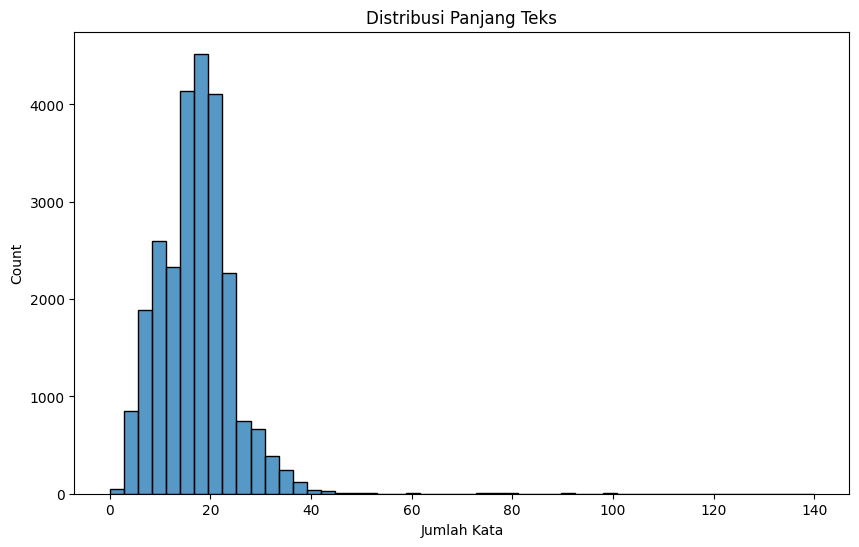

In [4]:
# 3. Visualisasi
plt.figure(figsize=(15, 6))
sns.countplot(data=df, x='category', order=df['category'].value_counts().index)
plt.xticks(rotation=45)
plt.title('Distribusi Kategori Berita')
plt.tight_layout()
plt.savefig('category_distribution.png')
plt.show()

df['text_length'] = df['cleaned_text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
sns.histplot(df['text_length'], bins=50)
plt.title('Distribusi Panjang Teks')
plt.xlabel('Jumlah Kata')
plt.savefig('text_length_distribution.png')
plt.show()

# 4. Split Data
X = df['cleaned_text']
y = df['category']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

## Ekstraksi Fitur, Pembuatan Model, Training, dan Evaluasi.

### Ekstraksi Fitur

In [5]:
# Ekstraksi Fitur
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

### Pembuatan Model SVM, Training dan Evaluasi

In [6]:
# Training dengan Grid Search
parameters = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

svc = SVC(random_state=42)
clf = GridSearchCV(svc, parameters, cv=3, n_jobs=-1, verbose=1)
clf.fit(X_train_tfidf, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


GridSearchCV(cv=3, estimator=SVC(random_state=42), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf']},
             verbose=1)


SVM Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
SVM Accuracy: 0.8636

Classification Report:
                precision    recall  f1-score   support

      BUSINESS       0.81      0.86      0.83      1000
 ENTERTAINMENT       0.81      0.85      0.83      1000
      POLITICS       0.85      0.82      0.84      1000
        SPORTS       0.91      0.89      0.90      1000
STYLE & BEAUTY       0.95      0.89      0.92      1000

      accuracy                           0.86      5000
     macro avg       0.87      0.86      0.86      5000
  weighted avg       0.87      0.86      0.86      5000



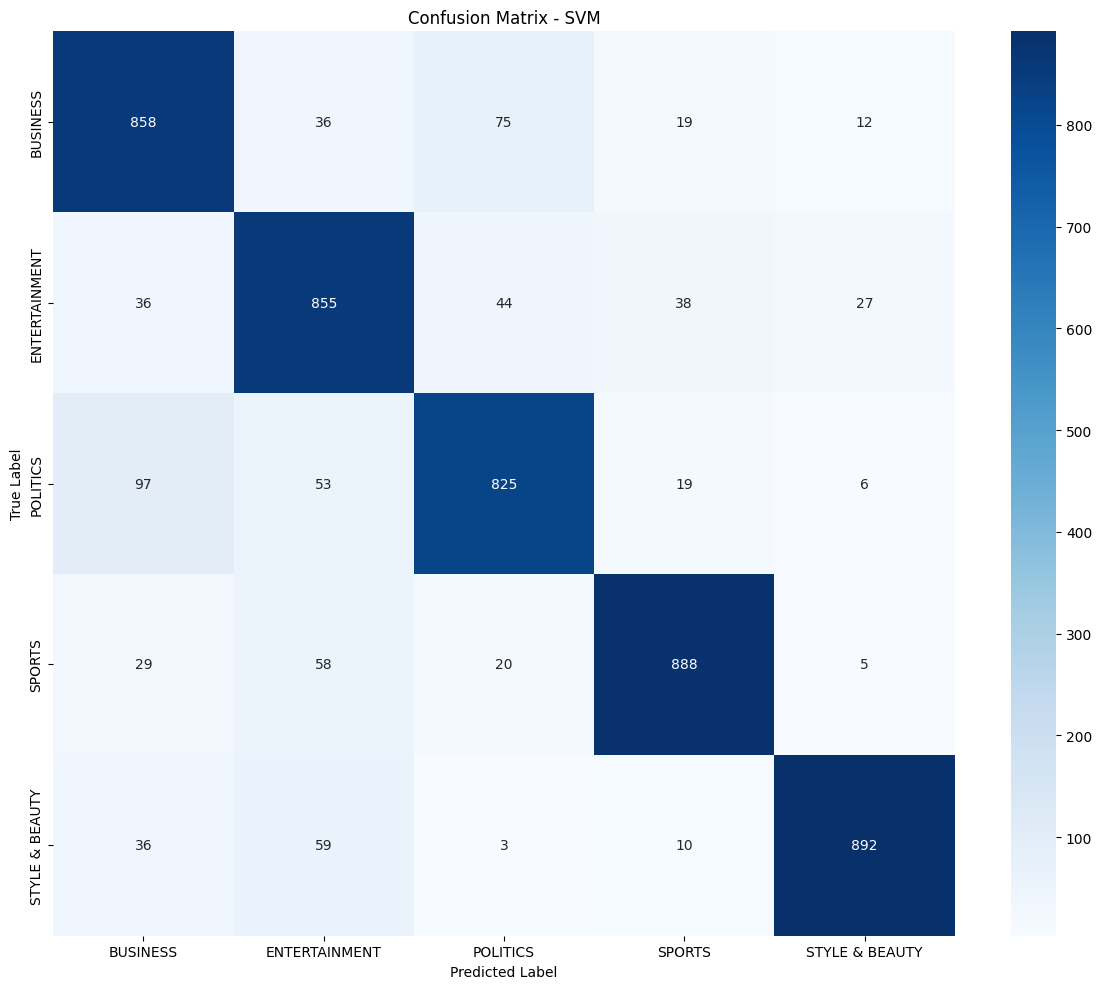

In [7]:
# Evaluasi
best_svc = clf.best_estimator_
y_pred_svm = best_svc.predict(X_test_tfidf)

print("\nSVM Best Parameters:", clf.best_params_)
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_svm))

# Confusion Matrix
plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=best_svc.classes_, 
            yticklabels=best_svc.classes_)
plt.title('Confusion Matrix - SVM')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('svm_confusion_matrix.png')
plt.show()

### Pembuatan Model Logistic Regression, Training dan Evaluasi

In [8]:
from sklearn.linear_model import LogisticRegression

# Training dengan Grid Search untuk Logistic Regression
logreg_params = {
    'C': [0.1, 1, 10],
    'solver': ['liblinear', 'lbfgs'],
    'max_iter': [1000]
}

logreg = LogisticRegression(random_state=42, multi_class='auto')
logreg_clf = GridSearchCV(logreg, logreg_params, cv=3, n_jobs=-1, verbose=1)
logreg_clf.fit(X_train_tfidf, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


c:\Users\tegar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


GridSearchCV(cv=3,
             estimator=LogisticRegression(multi_class='auto', random_state=42),
             n_jobs=-1,
             param_grid={'C': [0.1, 1, 10], 'max_iter': [1000],
                         'solver': ['liblinear', 'lbfgs']},
             verbose=1)


Logistic Regression Best Parameters: {'C': 10, 'max_iter': 1000, 'solver': 'liblinear'}
Logistic Regression Accuracy: 0.8608

Classification Report:
                precision    recall  f1-score   support

      BUSINESS       0.82      0.84      0.83      1000
 ENTERTAINMENT       0.82      0.84      0.83      1000
      POLITICS       0.85      0.83      0.84      1000
        SPORTS       0.90      0.90      0.90      1000
STYLE & BEAUTY       0.93      0.90      0.91      1000

      accuracy                           0.86      5000
     macro avg       0.86      0.86      0.86      5000
  weighted avg       0.86      0.86      0.86      5000



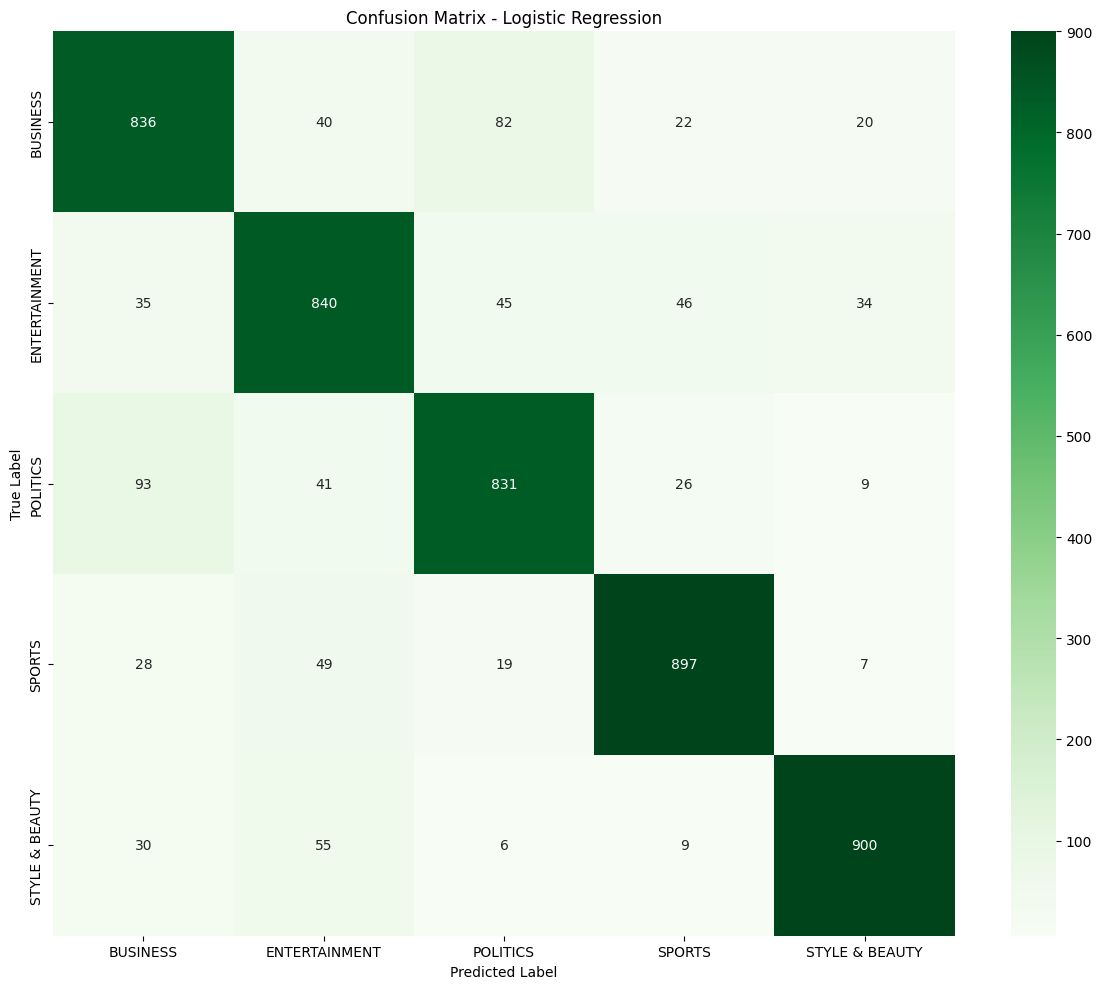

In [9]:
# Evaluasi
best_logreg = logreg_clf.best_estimator_
y_pred_logreg = best_logreg.predict(X_test_tfidf)

print("\nLogistic Regression Best Parameters:", logreg_clf.best_params_)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_logreg))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_logreg))

# Confusion Matrix
plt.figure(figsize=(12, 10))
cm_logreg = confusion_matrix(y_test, y_pred_logreg)
sns.heatmap(cm_logreg, annot=True, fmt='d', cmap='Greens', 
            xticklabels=best_logreg.classes_, 
            yticklabels=best_logreg.classes_)
plt.title('Confusion Matrix - Logistic Regression')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('logreg_confusion_matrix.png')
plt.show()

### Pembuatan Dataframe, Model DistilBERT, Training dan Evaluasi

In [10]:
# Tokenization & Dataset Preparation
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

class NewsDataset(Dataset):
    def __init__(self, texts, labels, label2id):
        self.texts = texts.tolist()
        self.labels = [label2id[label] for label in labels]
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding='max_length',
            max_length=64,
            return_tensors='pt'
        )
        item = {key: val.squeeze(0) for key, val in encoding.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

# Label encoding
label2id = {cat: i for i, cat in enumerate(categories)}
id2label = {i: cat for cat, i in label2id.items()}

train_dataset = NewsDataset(X_train, y_train, label2id)
test_dataset = NewsDataset(X_test, y_test, label2id)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [11]:
# Model Preparation
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=len(categories)
).to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)

# Training Loop 
model.train()
for epoch in range(5):
    loop = tqdm(train_loader, desc="Training")
    for batch in loop:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loop.set_postfix(loss=loss.item())

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\tegar\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Training:   0%|          | 0/1250 [00:00<?, ?it/s]c:\Users\tegar\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\models\distilbert\modeling_distilbert.py:403: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cu

Evaluating: 100%|██████████| 157/157 [00:20<00:00,  7.84it/s]


DistilBERT Accuracy: 0.8876

Classification Report:
                precision    recall  f1-score   support

      POLITICS       0.87      0.86      0.87      1000
 ENTERTAINMENT       0.84      0.88      0.86      1000
        SPORTS       0.92      0.92      0.92      1000
STYLE & BEAUTY       0.91      0.95      0.93      1000
      BUSINESS       0.90      0.81      0.86      1000

      accuracy                           0.89      5000
     macro avg       0.89      0.89      0.89      5000
  weighted avg       0.89      0.89      0.89      5000



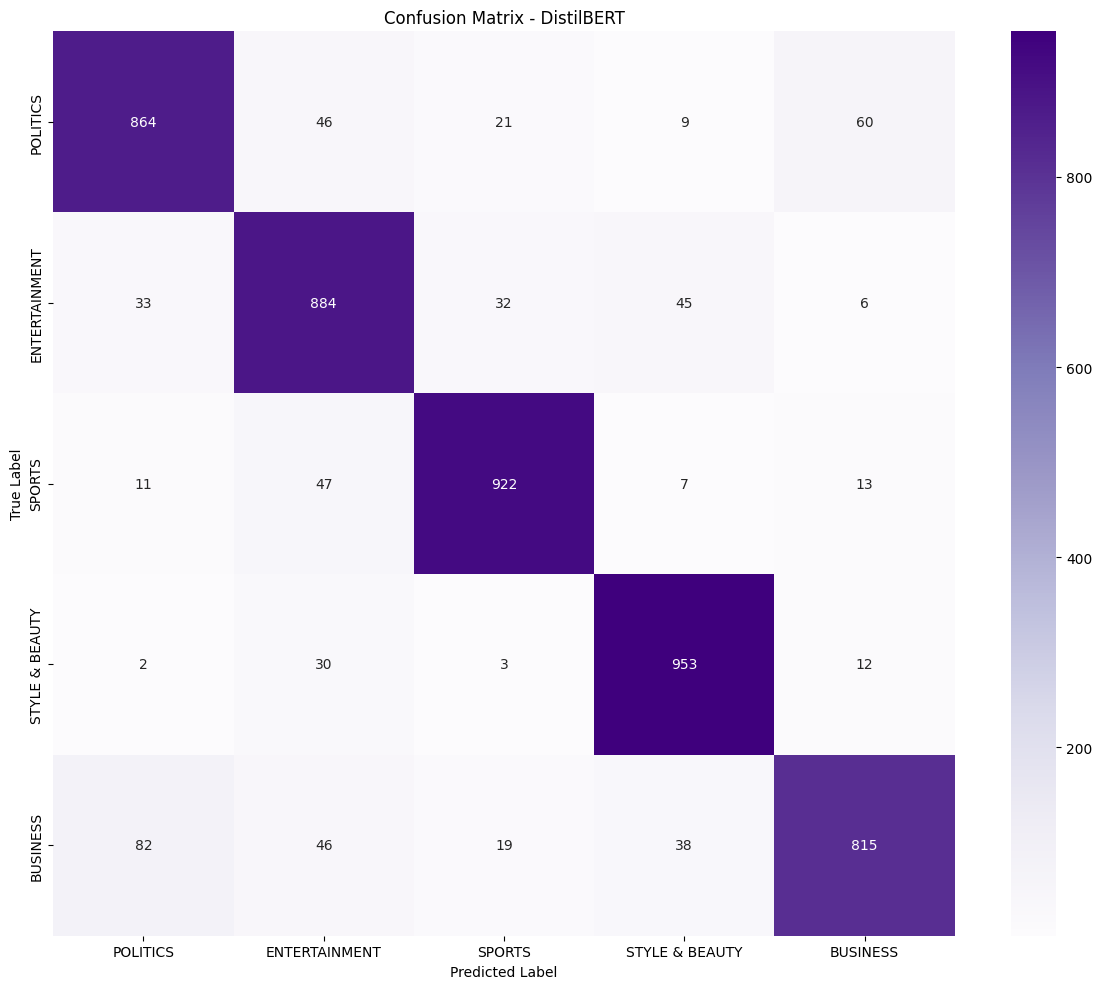

In [12]:
# Evaluasi 
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Evaluating"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("DistilBERT Accuracy:", accuracy_score(all_labels, all_preds))
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=categories))

# Confusion matrix
plt.figure(figsize=(12, 10))
cm_bert = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm_bert, annot=True, fmt='d', cmap='Purples',
            xticklabels=categories,
            yticklabels=categories)
plt.title('Confusion Matrix - DistilBERT')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('distilbert_confusion_matrix.png')
plt.show()

## Evaluasi Seluruh Model dan Kesimpulan

C:\Users\tegar\AppData\Local\Temp\ipykernel_3204\3023609380.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()), palette='viridis')


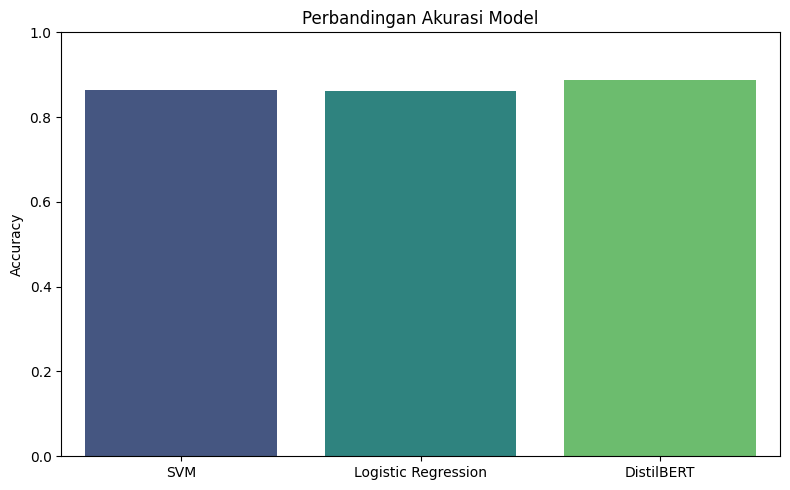

In [13]:
# Bandingkan akurasi semua model 
accuracies = {
    'SVM': accuracy_score(y_test, y_pred_svm),
    'Logistic Regression': accuracy_score(y_test, y_pred_logreg),
    'DistilBERT': accuracy_score(all_labels, all_preds)
}

plt.figure(figsize=(8, 5))
sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()), palette='viridis')
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Perbandingan Akurasi Model')
plt.tight_layout()
plt.savefig('model_comparison_accuracy.png')
plt.show()

### Kesimpulan

Berdasarkan hasil evaluasi pada tiga model klasifikasi teks untuk kategori berita HuffPost:

- **SVM** menghasilkan akurasi: 86% (Dengan waktu training 6 Menit 34 detik)
- **Logistic Regression** menghasilkan akurasi: 86% (Dengan waktu training 3.8 detik)
- **DistilBERT** menghasilkan akurasi tertinggi: 89% (Dengan waktu training 22 menit 9 detik)

Hal ini menunjukkan bahwa model berbasis transformer (DistilBERT) mampu memahami konteks dan makna teks lebih baik dibandingkan model klasik berbasis fitur (SVM dan Logistic Regression),sehingga memberikan performa klasifikasi yang lebih baik pada data headline dan deskripsi singkat berita.

Namun, model klasik seperti SVM dan Logistic Regression tetap memberikan hasil yang sangat kompetitif dengan waktu pelatihan yang jauh lebih singkat dan kebutuhan komputasi yang lebih rendah, terlebih lagi Logistic Regression yang jauh sangat cepat dibanding svm walaupun dengan akurasi yang sama. Pemilihan model terbaik dapat disesuaikan dengan kebutuhan, ketersediaan sumber daya, dan kompleksitas data.

Secara keseluruhan, seluruh model sudah cukup baik dalam mengklasifikasikan berita ke dalam lima kategori utama.